In [1]:
## XGBoost 
# State 1 hot 
# Rurality Data
# SVI poverty index
# Minority?


In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import pairwise
from sklearn.model_selection import cross_val_score
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [96]:
main_path = Path.cwd().parent.parent
data_path = main_path / 'Data'

#svi = pd.read_csv( data_path / 'Master Project Data' /'SVI Tract Data.csv',  )


In [97]:
# import stored methods 
path = Path.cwd().parent.parent
LoadAndCleanACS = main_path /'src' /'data'/ 'LoadAndCleanACS.py'
LoadAndCleanARCP = main_path /'src' /'data'/ 'LoadAndCleanARCP.py'

# Run methods to obtain clean datasets 
%run $LoadAndCleanACS
%run $LoadAndCleanARCP


                     Pair Var 1                    Pair Var 2  Corr Value
59         house_pct_non_family          house_pct_live_alone    0.907753
25               race_pct_white              race_pct_whitenh    0.851387
36            race_pct_nonwhite           race_pct_nonwhitenh    0.851387
37            race_pct_nonwhite                race_pct_black    0.802072
48             house_pct_family      house_pct_family_married    0.757961
104    house_pct_complete_plumb    house_pct_complete_kitchen    0.752488
109  house_pct_incomplete_plumb  house_pct_incomplete_kitchen    0.752488
92         heat_pct_utility_gas          heat_pct_electricity   -0.732439
105    house_pct_complete_plumb  house_pct_incomplete_kitchen   -0.752488
108  house_pct_incomplete_plumb    house_pct_complete_kitchen   -0.752488
53     house_pct_family_married          house_pct_non_family   -0.757961
28               race_pct_white                race_pct_black   -0.802072
31             race_pct_whitenh       

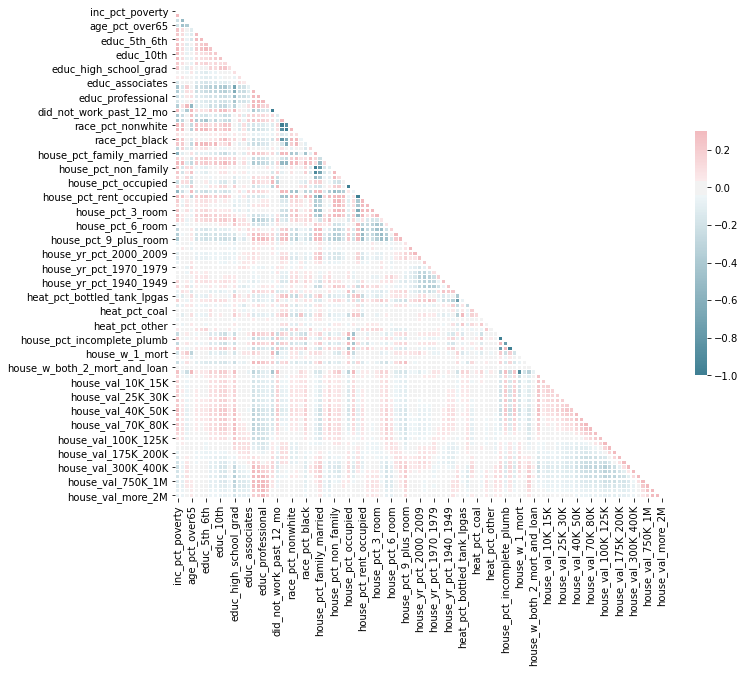

In [98]:
#Find correlated features in ACS dataset and identify the highly correlated relationships

# Create ACS correlation matrix
corr = ACS.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
# Filtering out lower/upper triangular duplicates 
corr_high = corr[abs(corr) > 0.7].stack().reset_index()
corr_high = corr_high[corr_high['level_0'].astype(str)!=corr_high['level_1'].astype(str)]
corr_high['ordered-cols'] = corr_high.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)
corr_high = corr_high.drop_duplicates(['ordered-cols'])
corr_high.drop(['ordered-cols'], axis=1, inplace=True)
corr_high.columns = ['Pair Var 1', 'Pair Var 2', 'Corr Value']

# Display highly correlated pairs
print(corr_high.sort_values(by=['Corr Value'], ascending=False))


# Based on feature importance experiments, select features with consistence importance across annual predictions
ACS_reduced = ACS[['house_yr_pct_earlier_1939','house_yr_pct_1940_1949', 'house_pct_family_married', 'race_pct_white',
          'worked_past_12_mo', 'heat_pct_fueloil_kerosene','heat_pct_electricity','house_w_both_2_mort_and_loan', 'educ_bachelors', 'house_pct_live_alone', 
          'educ_some_col_no_grad','educ_docterate','house_pct_ownd_occupied', 'house_w_home_equity_loan', 'house_val_500K_750K',
           'house_val_20K_25K','house_pct_family_female_hh']]


#From highly correlated pairs, remove one of the Pair Vars from the ACS dataset except for the 'mort' variables
ACS = ACS.drop(['house_pct_vacant', 'did_not_work_past_12_mo', 'house_pct_non_family', 'house_pct_rent_occupied',
                           'race_pct_nonwhite', 'race_pct_nonwhitenh', 'house_pct_incomplete_plumb',
                           'house_pct_incomplete_kitchen', 'race_pct_whitenh','house_no_mort',
                           'race_pct_black','house_pct_live_alone','house_pct_family_married'], axis=1) 





print (ACS.head())


In [102]:
# smoke detector statistical model munging
sm = pd.read_csv(  data_path /'Model Outputs'/'SmokeAlarmModelOutput.csv')
sm['geoid'] = sm['geoid'].str[2:]
sm['tract'] = sm['geoid'].str[:-1]
sm.drop(columns = 'Unnamed: 0', inplace = True)
sm.set_index('geoid', inplace =  True)
sm_all = sm.copy()
sm_all = sm[ sm['geography'].isin(['county','state']) ]

sm = sm[ sm['geography'].isin(['tract','block']) ]


In [207]:
def create_rurality_data(sm,subset_county = False): 
    #Rurality Data Munging 
    rd = pd.read_csv( data_path / 'Master Project Data' /'Tract Rurality Data.csv', dtype = {'FIPS':'object'},encoding = 'latin-1' )
    rd['Population Density (per square mile), 2010'] =  rd['Population Density (per square mile), 2010'].str.replace(',','').astype('float')
    rd = rd.iloc[:,[0,2,5,6,8]]
    block_tract = sm['tract'].to_frame()
    block_tract = block_tract.reset_index()
    rd = block_tract.merge(rd, how = 'left', left_on = 'tract' , right_on ='FIPS')
    rd.set_index('geoid',inplace= True)
    rd = rd.iloc[:,2:]
    rd['Select State'] = rd['Select State'].astype('category')

    # add state level model estimates 
    sms = pd.rd = pd.read_csv( data_path /'Model Outputs'/'Smoke_Alarm_Single_Level'/ 'SmokeAlarmModelState.csv')
    sms['geoid'] = sms['geoid'].str[2:]
    sms =  sms.loc[:,['geoid','detectors_found_prc']]
    sms = sms.rename(columns= {'geoid':'state_geoid'}  )

    rd['state_geoid'] = rd.index.str[:2]
    rd = rd.reset_index()
    rd = rd.merge(sms,how = 'left', on = 'state_geoid' )
    rd.drop('state_geoid',axis = 1,inplace = True)
    rd = rd.rename(columns = {'detectors_found_prc':'state_detectors_found_prc'}) 
    rd = rd.set_index('geoid')


    # add county level estimates
    smc = pd.read_csv( data_path /'Model Outputs'/'Smoke_Alarm_Single_Level'/ 'SmokeAlarmModelCounty.csv')
    smc['geoid'] = smc['geoid'].str[2:]
    if subset_county:
        smc.iloc[0::2,:] = np.nan
    smc =  smc.loc[:,['geoid','detectors_found_prc']]
    smc = smc.rename(columns= {'geoid':'county_geoid'}  )

    rd['county_geoid'] = rd.index.str[:5]
    rd = rd.reset_index()
    rd = rd.merge(smc,how = 'left', on = 'county_geoid' )
    rd.drop('county_geoid',axis = 1,inplace = True)
    rd = rd.rename(columns = {'detectors_found_prc':'county_detectors_found_prc'}) 
    rd = rd.set_index('geoid')
    rd = rd.iloc[:,3:]

    return rd 

# alternative 1 hot based encoding
#rd = rd.merge( pd.get_dummies(rd['Select State']), how = 'left', on= 'geoid')


In [208]:
rd = create_rurality_data(sm,True)
rd_all = create_rurality_data(sm_all)

In [209]:
def train_model(X = rd, y= sm, ACS = pd.DataFrame(),predict ='Presence', modeltype='XGBoost'):
    from scipy.stats import zscore, pearsonr
    from sklearn.metrics import auc, accuracy_score, confusion_matrix,mean_squared_error,mean_absolute_error,roc_auc_score, r2_score

    assert(predict in ['Presence', 'Working']) 
   
    
    # Define model types & parameters 
    
    if modeltype =='LinearRegression':
        from sklearn.linear_model import LinearRegression
        model = LinearRegression()
    if modeltype =='ElasticNet':    
        from sklearn.linear_model import ElasticNet
        model = ElasticNet()
    if modeltype =='Ridge':    
        from sklearn.linear_model import Ridge
        model = Ridge()
    if modeltype =='Lasso':    
        from sklearn.linear_model import Lasso
        model = Lasso()       
        
       
        
    elif modeltype =='XGBoost':
        import xgboost as xgb 
        model = xgb.XGBRegressor(objective = 'reg:squarederror',random_state = 0)
            
  
    if  predict == 'Presence':
        y = y['detectors_found_prc']
    elif predict =='Working':
        y = y['detectors_working_prc']


    # merge in ACS Data into X unless NFIRS-Only model
    if not ACS.empty:
        X = X.merge(ACS, how ='left',left_index = True, right_index = True)
        X = X.dropna()
        y = y.filter(X.index)
    
    # Create 80/20 training/testing set split
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .2 )

    # Perform cross-validation 

    #scaler = preprocessing.StandardScaler().fit(X)
    #scaler.transform(X)
    #print ('Cross Val Score:')
    #print(cross_val_score(model, X, y))

    # Standardize features by removing the mean and scaling to unit variance
    
    #scaler = preprocessing.StandardScaler().fit(X_train)
    #X_columns = X_train.columns
    #X_train =  pd.DataFrame(scaler.transform(X_train), columns = X_columns )
    #X_test  =  pd.DataFrame(scaler.transform(X_test) , columns = X_columns )

    # Fit model to training set

    model = model.fit(X_train,y_train)

    # Calculate training set performance
    train_predictions = model.predict(X_train)
    print('-----Training_Performance------')
    print(mean_squared_error(y_train, train_predictions))
    print ('Test RMSE: {}'.format(mean_squared_error(y_train, train_predictions, squared = False)) )
    print ('Test MAE: {}'.format(mean_absolute_error(y_train, train_predictions)) )
    
    
    # Calculate test set performance
    test_predictions = model.predict(X_test)
    print ('-----Test Performance ----- ')
    print ('Test RMSE: {}'.format(mean_squared_error(y_test, test_predictions, squared = False)) )
    print ('Test MAE: {}'.format(mean_absolute_error(y_test, test_predictions)) )
    sns.scatterplot(y_test,test_predictions) 
    plt.show()
    print ('Test Correlation: {}'.format(pearsonr(y_test, test_predictions)) )
    print ('Test R-squared: {}'.format(r2_score(y_test, test_predictions)) )


    #Calculate feature importance for each model
    if modeltype == 'XGBoost':
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        print("\n Feature ranking:")
        for f in range(len(X_test.columns)):
            print("%d. %s (%f)" % (f + 1, X_test.columns[indices[f]], importances[indices[f]])) 


    return  model,X_test,y_test



-----Training_Performance------
12.386680696272483
Test RMSE: 3.519471650158939
Test MAE: 2.583401065060167
-----Test Performance ----- 
Test RMSE: 14.031249805854888
Test MAE: 10.428994324790654


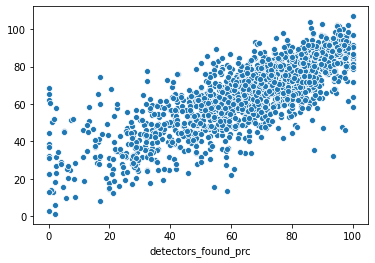

Test Correlation: (0.7769328377901491, 3.56496617527e-313)
Test R-squared: 0.6021319414949866

 Feature ranking:
1. county_detectors_found_prc (0.293099)
2. race_pct_hisp (0.019135)
3. house_val_400K_500K (0.013546)
4. house_val_35K_40K (0.012209)
5. race_pct_amind (0.012173)
6. house_val_1M_1.5M (0.011866)
7. house_val_300K_400K (0.011579)
8. house_yr_pct_1950_1959 (0.011507)
9. heat_pct_electricity (0.011388)
10. educ_professional (0.011266)
11. race_pct_white (0.010976)
12. house_val_30K_35K (0.010932)
13. house_yr_pct_1990_1999 (0.010640)
14. house_val_125K_150K (0.010525)
15. house_val_40K_50K (0.010416)
16. house_pct_ownd_occupied (0.010251)
17. house_w_home_equity_loan (0.010055)
18. house_val_less_10K (0.010026)
19. house_val_500K_750K (0.009859)
20. age_pct_over65 (0.009710)
21. house_yr_pct_1940_1949 (0.009643)
22. house_pct_complete_kitchen (0.009596)
23. house_val_200K_250K (0.009488)
24. house_val_more_2M (0.009360)
25. heat_pct_utility_gas (0.009279)
26. house_val_1.5M_2M

In [210]:
mdl,X_test,y_test = train_model(X = rd, y = sm , ACS = ACS  ,modeltype= 'XGBoost')

-----Training_Performance------
25.79542652215887
Test RMSE: 5.078919818441602
Test MAE: 3.7000653974361435
-----Test Performance ----- 
Test RMSE: 12.668979435117217
Test MAE: 9.33171797751303


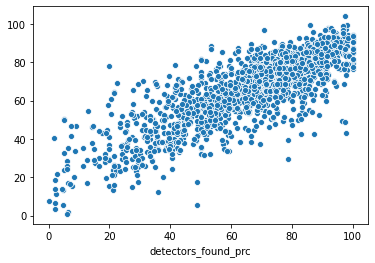

Test Correlation: (0.8101798242312378, 0.0)
Test R-squared: 0.6561325817920665

 Feature ranking:
1. county_detectors_found_prc (0.536467)
2. house_val_500K_750K (0.031943)
3. heat_pct_electricity (0.029349)
4. house_pct_ownd_occupied (0.029217)
5. Population Density (per square mile), 2010 (0.029057)
6. race_pct_white (0.028991)
7. educ_bachelors (0.026996)
8. house_pct_family_female_hh (0.025879)
9. educ_some_col_no_grad (0.025292)
10. house_w_home_equity_loan (0.025055)
11. state_detectors_found_prc (0.024777)
12. worked_past_12_mo (0.024428)
13. house_val_20K_25K (0.024206)
14. house_pct_live_alone (0.022178)
15. house_yr_pct_1940_1949 (0.021758)
16. house_pct_family_married (0.020834)
17. educ_docterate (0.019887)
18. house_yr_pct_earlier_1939 (0.019832)
19. heat_pct_fueloil_kerosene (0.018308)
20. house_w_both_2_mort_and_loan (0.015546)


In [211]:
mdl2,X_test,y_test =train_model(X = rd, y = sm , ACS = ACS_reduced  ,modeltype= 'XGBoost')

-----Training_Performance------
118.44041232289753
Test RMSE: 10.88303323172807
Test MAE: 7.9789471630226085
-----Test Performance ----- 
Test RMSE: 12.568940176001034
Test MAE: 9.129445487945507


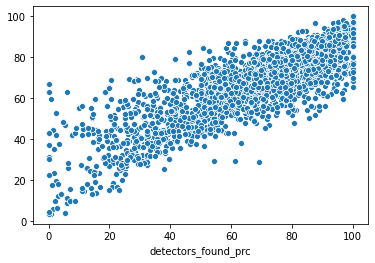

Test Correlation: (0.8262517305684748, 0.0)
Test R-squared: 0.6743870210185444

 Feature ranking:
1. county_detectors_found_prc (0.586590)
2. state_detectors_found_prc (0.308494)
3. Population Density (per square mile), 2010 (0.104916)


In [212]:
mdl3,X_test,y_test=train_model(X = rd, y = sm ,modeltype= 'XGBoost')

In [221]:
sm_all['Full_Predictions'] =  mdl.predict(rd_all.merge(ACS,how = 'left', left_index = True, right_index = True) )
sm_all['Reduced_ACS_Predictions'] =  mdl2.predict(rd_all.merge(ACS_reduced,how = 'left', left_index = True, right_index = True) )
sm_all['No_ACS_Predictions'] =  mdl3.predict(rd_all )
sm_all['Avg_Predictions']  = (sm_all['No_ACS_Predictions'] +sm_all['Reduced_ACS_Predictions']) /2 

In [222]:
sm_all.loc[:,['num_surveys','geography',
              'detectors_found_prc',
              'detectors_working_prc',
              'Full_Predictions',
              'Reduced_ACS_Predictions',
              'No_ACS_Predictions','Avg_Predictions'] ]

,num_surveys,geography,detectors_found_prc,detectors_working_prc,Full_Predictions,Reduced_ACS_Predictions,No_ACS_Predictions,Avg_Predictions
geoid,,,,,,,,
010030101001,95.0,county,77.89,52.63,75.878403,70.148743,87.395988,78.772369
010030101002,95.0,county,77.89,52.63,81.255760,76.419098,87.395988,81.907547
010030101003,95.0,county,77.89,52.63,75.651581,78.331039,87.395988,82.863510
010030102001,95.0,county,77.89,52.63,78.241516,78.540535,79.445091,78.992813
010030102002,95.0,county,77.89,52.63,79.032738,83.642357,79.445091,81.543724
...,...,...,...,...,...,...,...,...
560459511001,892.0,state,63.00,38.90,64.821472,55.331581,66.333069,60.832325
560459511002,892.0,state,63.00,38.90,68.022453,52.054264,66.333069,59.193665
560459513001,892.0,state,63.00,38.90,59.215946,58.954403,61.888123,60.421265


In [215]:
sm_all.columns

Index(['num_surveys', 'detectors_found_total', 'detectors_found_prc',
       'detectors_found_CI', 'detectors_working_total',
       'detectors_working_prc', 'detectors_working_CI', 'geography', 'tract',
       'Predictions', 'Full_Predictions', 'Reduced_ACS_Predictions',
       'No_ACS_Predictions'],
      dtype='object')

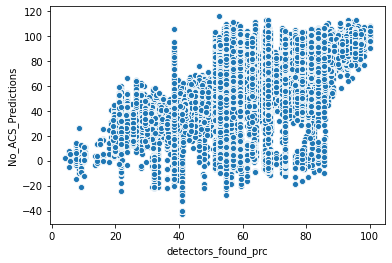

In [223]:
sns.scatterplot(sm_all['detectors_found_prc'],sm_all['No_ACS_Predictions'])

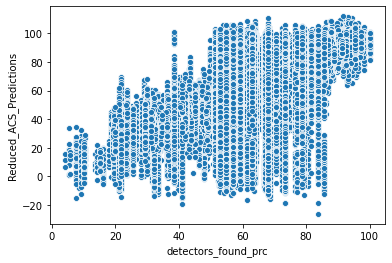

In [217]:
sns.scatterplot(sm_all['detectors_found_prc'],sm_all['Reduced_ACS_Predictions'])

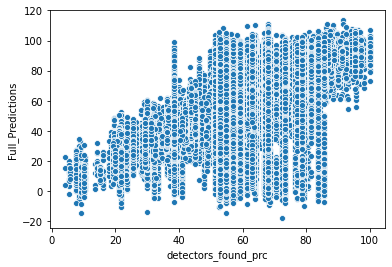

In [218]:
sns.scatterplot(sm_all['detectors_found_prc'],sm_all['Full_Predictions'])


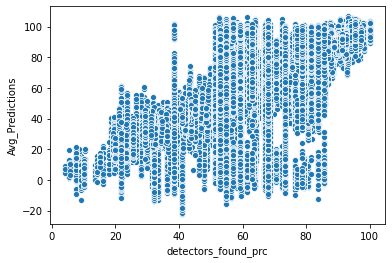

In [226]:
sns.scatterplot(sm_all['detectors_found_prc'],sm_all['Avg_Predictions'])
